<a href="https://colab.research.google.com/github/AkarshAnilkumar/Machine_Learning/blob/main/Chilli_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Chilli classification

Classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process



## Setup

Import TensorFlow and other necessary libraries:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
# data_dir = /content/drive/MyDrive/Chilli_Providence
data_dir = pathlib.Path('/content/drive/MyDrive/Chilli_Providence').with_suffix('')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2013


Here are some roses:

In [5]:
Bajji_Chilli = list(data_dir.glob('Bajji Chilli/*'))

In [6]:
Ball_Chilli = list(data_dir.glob('Ball_Chilli/*'))

In [7]:
Capsicum = list(data_dir.glob('Capsicum/*'))

In [8]:
Curd = list(data_dir.glob('Curd Chilli/*'))

In [9]:
Green_Bell_Pepper = list(data_dir.glob('Green Bell Pepper/*'))

In [10]:
Green_Chilli = list(data_dir.glob('Green Chilli/*'))

In [11]:
Habanero_Chilli = list(data_dir.glob('Habanero Chilli/*'))

In [12]:
Jalapeno_Chilli = list(data_dir.glob('Jalapeno Chilli/*'))

In [13]:
Kanthari_Chilli = list(data_dir.glob('Kanthari Chilli/*'))

In [14]:
Kashmiri_Chilli = list(data_dir.glob('Kashmiri Chilli/*'))

In [15]:
Red_Bell_Pepper = list(data_dir.glob('Red Bell Pepper/*'))

In [16]:
Yellow_Bell_Pepper = list(data_dir.glob('Yellow Bell Pepper/*'))

### Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2248 files belonging to 14 classes.
Using 1799 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2248 files belonging to 14 classes.
Using 449 files for validation.


In [20]:
class_names = train_ds.class_names
print(class_names)

['Bajji Chilli', 'Ball_Chilli', 'Capsicum', 'Chilli Not Found', 'Curd Chilli', 'Green Bell Pepper', 'Green Chilli', 'Habanero Chilli', 'Jalapeno Chilli', 'Kanthari Chilli', 'Kashmiri Chilli', 'Red Bell Pepper', 'Red Chilli', 'Yellow Bell Pepper']


## Visualize the data

The first nine images from the training dataset:

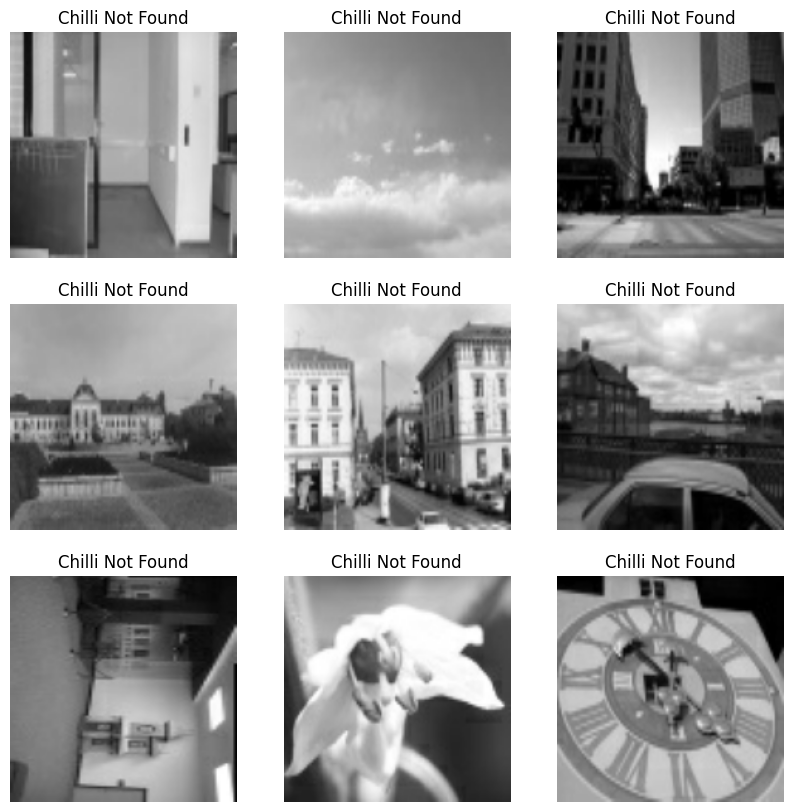

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [24]:
normalization_layer = layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9315907


## A basic Keras model



In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model



In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary



In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
57/57 [==============================] - 70s 1s/step - loss: 1.5196 - accuracy: 0.6598 - val_loss: 0.8193 - val_accuracy: 0.7149
Epoch 2/10
57/57 [==============================] - 1s 22ms/step - loss: 0.7661 - accuracy: 0.7476 - val_loss: 0.6427 - val_accuracy: 0.7817
Epoch 3/10
57/57 [==============================] - 1s 20ms/step - loss: 0.5687 - accuracy: 0.8121 - val_loss: 0.5126 - val_accuracy: 0.8374
Epoch 4/10
57/57 [==============================] - 1s 22ms/step - loss: 0.4351 - accuracy: 0.8555 - val_loss: 0.4508 - val_accuracy: 0.8463
Epoch 5/10
57/57 [==============================] - 1s 21ms/step - loss: 0.3021 - accuracy: 0.8949 - val_loss: 0.5223 - val_accuracy: 0.8396
Epoch 6/10
57/57 [==============================] - 1s 22ms/step - loss: 0.2484 - accuracy: 0.9172 - val_loss: 0.4576 - val_accuracy: 0.8597
Epoch 7/10
57/57 [==============================] - 1s 20ms/step - loss: 0.1857 - accuracy: 0.9327 - val_loss: 0.4538 - val_accuracy: 0.8641
Epoch 8/10
57/

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

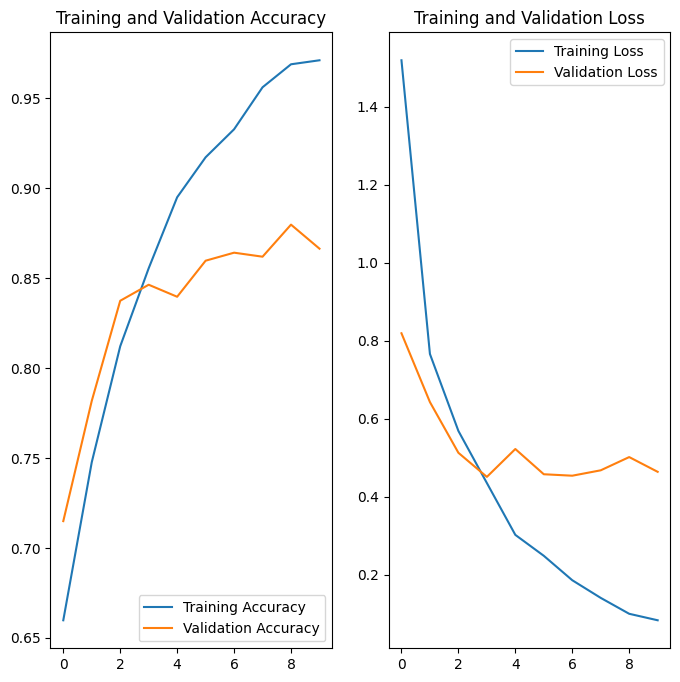

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.



In [31]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples:

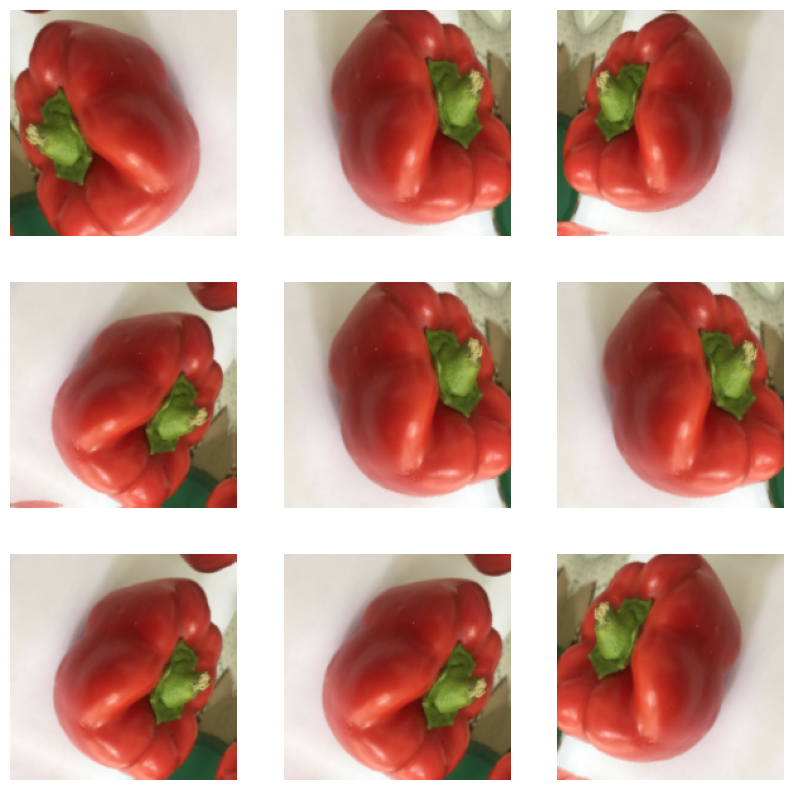

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout



In [33]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [36]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
57/57 [==============================] - 4s 34ms/step - loss: 1.1978 - accuracy: 0.6898 - val_loss: 0.7276 - val_accuracy: 0.7639
Epoch 2/15
57/57 [==============================] - 2s 31ms/step - loss: 0.6984 - accuracy: 0.7765 - val_loss: 0.6077 - val_accuracy: 0.7951
Epoch 3/15
57/57 [==============================] - 2s 29ms/step - loss: 0.5653 - accuracy: 0.8221 - val_loss: 0.5261 - val_accuracy: 0.8151
Epoch 4/15
57/57 [==============================] - 2s 28ms/step - loss: 0.4882 - accuracy: 0.8299 - val_loss: 0.5186 - val_accuracy: 0.8196
Epoch 5/15
57/57 [==============================] - 2s 28ms/step - loss: 0.4334 - accuracy: 0.8566 - val_loss: 0.4058 - val_accuracy: 0.8552
Epoch 6/15
57/57 [==============================] - 2s 28ms/step - loss: 0.3937 - accuracy: 0.8660 - val_loss: 0.4349 - val_accuracy: 0.8374
Epoch 7/15
57/57 [==============================] - 2s 31ms/step - loss: 0.3874 - accuracy: 0.8610 - val_loss: 0.4309 - val_accuracy: 0.8575
Epoch 8/15
57

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

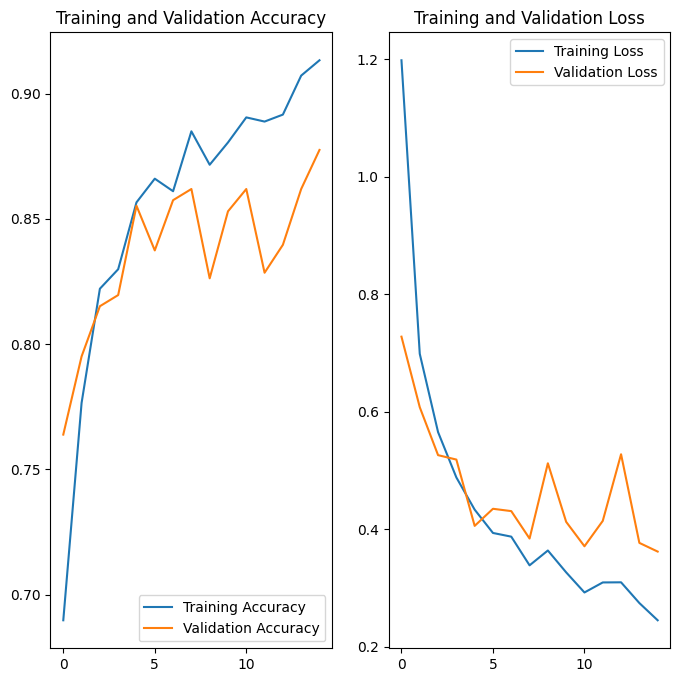

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

In [48]:
# test_url = "https://www.veggycation.com.au/siteassets/veggycationvegetable/capsicum-green.jpg"
# Capsicum_path = tf.keras.utils.get_file('Capsicum', origin=test_url)

# img = tf.keras.utils.load_img(
#     Capsicum_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

### Convert the Keras Sequential model to a TensorFlow Lite model



In [49]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [50]:
TF_MODEL_FILE_PATH = 'model.tflite' 

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [41]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [42]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [43]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [44]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to Red Bell Pepper with a 50.19 percent confidence.


In [45]:
print(np.max(np.abs(predictions - predictions_lite)))

2.861023e-06
